In [1]:
import cv2
from skimage import io, transform, exposure
import numpy as np
import random

In [2]:
# helper function for data visualization
import matplotlib.pyplot as plt
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [75]:
class rescaleTo(object):
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        imidx, image, label = sample['imidx'], sample['image'], sample['label']

        h, w = image.shape[:2]

        # small side set
        if h > w:
            new_h, new_w = self.output_size*h/w, self.output_size
        else:
            new_h, new_w = self.output_size, self.output_size*w/h

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (self.output_size, self.output_size), mode='constant', anti_aliasing=True, anti_aliasing_sigma=None)
        lbl = transform.resize(label, (self.output_size, self.output_size), mode='constant', order=0, preserve_range=True)

        return {'imidx': imidx, 'image': img, 'label': lbl}


class RandomScaleShiftRotate():

    def __init__(self,):
        pass

    def __call__(self, sample):
        imidx, image, label = sample['imidx'], sample['image'], sample['label']

        # raw info
        h, w = image.shape[:2]
        src = np.array([[-w/2, -h/2],[w/2, -h/2],[w/2, h/2],[-w/2, h/2]], np.float32)
        
        # -- define params
        # trans
        dshift = np.random.uniform(-0.0625, 0.0625, 2)
        # scale
        dscale_x = np.random.uniform(-0.3, 0.3)
        dscale_y = np.random.uniform(-0.3, 0.3)
        # rotate
        dangle = np.random.uniform(-90, 90)
        cos = np.cos(dangle/180*np.pi)
        sin = np.sin(dangle/180*np.pi)
        # ----------------------

        # trans
        tx, ty = dshift*min(h, w)
        src = src+[tx, ty]
        
        # rescale
        sx, sy = 1 + dscale_x, 1+ dscale_y
        src = src*[sx, sy]

        #rotate
        x = (src*[cos, -sin]).sum(1) + w/2
        y = (src*[sin, cos]).sum(1) + h/2

        src = np.column_stack([x,y])
        dst = np.array([[0,0],[w,0],[w,h],[0,h]])
        
        s = src.astype(np.float32)
        d = dst.astype(np.float32)
        
        transform = cv2.getPerspectiveTransform(s, d)

        print(image.shape)
        print(label.shape)
        image = cv2.warpPerspective(image, transform, (w, h),
            flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

        mask = cv2.warpPerspective(label, transform, (w, h),
            flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
        
        label = mask[:,:,np.newaxis]
        # mask = mask.transpose(2,0,1)

        return {'imidx': imidx, 'image': image, 'label': label}


class Brightness(object):
    def __init__(self):
        pass

    def __call__(self, sample):
        
        if random.random() >= 0.5:
            return sample

        imidx, image, label = sample['imidx'], sample['image'], sample['label']

        gain = np.random.uniform(0.70, 1.30, 1)
        inverse = np.random.choice(2, 1)

        # image = image.astype(np.float32)/255

        if inverse==0:
            image = gain*np.log(image+1)
        else:
            image = gain*(2**image-1)

        # image = np.clip(image*255, 0, 255).astype(np.uint8)

        return {'imidx': imidx, 'image': image, 'label': label}


class RandomHorizontalFlip(object):
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, sample):
        imidx, image, label = sample['imidx'], sample['image'], sample['label']
        if random.random() < self.flip_prob:
            image = image[:, ::-1, :]
            label = label[:, ::-1, :]

        return {'imidx': imidx, 'image': image, 'label': label}


class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        imidx, image, label = sample['imidx'], sample['image'], sample['label']
        if random.random() >= 0.5:
            image = image[::-1]
            label = label[::-1]
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top: top + new_h, left: left + new_w]
        label = label[top: top + new_h, left: left + new_w]
        
        return {'imidx':imidx, 'image':image, 'label':label}


In [4]:
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform, color

class SegmentDataset(Dataset):
    def __init__(self, img_name_list, lbl_name_list, is_train, transform=None):
        # self.root_dir = root_dir
        # self.image_name_list = glob.glob(image_dir+'*.png')
        # self.label_name_list = glob.glob(label_dir+'*.png')
        self.image_name_list = img_name_list
        self.label_name_list = lbl_name_list
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.image_name_list)

    def __getitem__(self, idx):
        # image info
        # image = Image.open(self.image_name_list[idx]).convert('RGB')

        image = io.imread(self.image_name_list[idx])
        imname = self.image_name_list[idx]
        imidx = np.array([idx])
        
        if(len(self.label_name_list)==0):
            label_3 = np.zeros(image.shape)
        else:
            label_3 = io.imread(self.label_name_list[idx])

        label = np.zeros(label_3.shape[0:2])
        
        if(3==len(label_3.shape)):
            label = label_3[:,:,0]
        elif(2==len(label_3.shape)):
            label = label_3

        if(3==len(image.shape) and 2==len(label.shape)):
            label = label[:,:,np.newaxis]
        elif(2==len(image.shape) and 2==len(label.shape)):	
            image = image[:,:,np.newaxis]
            label = label[:,:,np.newaxis]

        sample = {'imidx':imname, 'image':image, 'label':label}
        
        if self.transform:
            sample = self.transform(sample)

        return sample
# -----------------------------------

In [76]:
import os
from torchvision import transforms

train_img_name_list =['/Users/ningyupeng/development/u2net/test_data/test_images/'+i for i in os.listdir('/Users/ningyupeng/development/u2net/test_data/test_images')]
train_lbl_name_list = [im.replace('test_images', 'piia_results').replace('JPG','png') for im in train_img_name_list]

train_dataset = SegmentDataset(
    img_name_list=train_img_name_list,
    lbl_name_list=train_lbl_name_list,
    is_train=True,
    transform=transforms.Compose([
        RandomScaleShiftRotate(),
        # rescaleTo(output_size=320),
        # RandomCrop(288),
        # RandomHorizontalFlip(flip_prob=0.5),
        # RandomColorJitter(),
        # Brightness()
        ]))

(1333, 1000, 3)
(1333, 1000, 1)


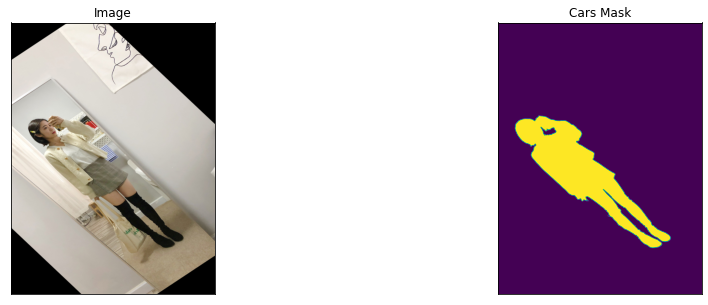

In [115]:

a = train_dataset[40]

image, mask = a['image'], a['label']

visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

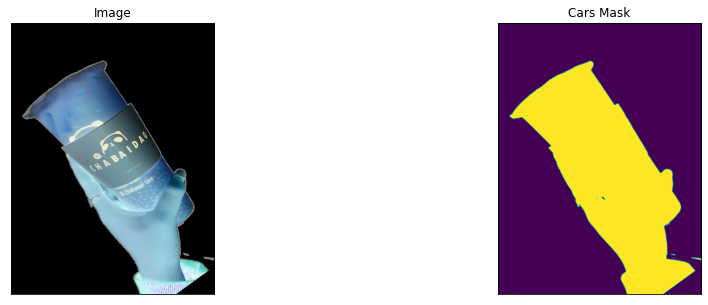

In [69]:
mask_ = mask/255
c = image*mask_*255
visualize(
    image=c.astype(np.uint8), 
    cars_mask=mask.squeeze(),
)